In [2]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd, tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
#from googletrans import Translator
from tensorflow import keras


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [ ]:
##This cell for all of data
'''
df1 = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv', usecols =['comment_text', 'toxic'] )
test = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
df2 = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv', usecols =['comment_text', 'toxic'])

train = pd.concat([df1, df2], axis = 0).reset_index(drop=True)

train.loc[train['toxic'] > 0.5, 'toxic'] = 1
train.loc[train['toxic'] <= 0.5, 'toxic'] = 0
'''

In [5]:
## This cell for Testing with simple data
train = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv', usecols =['comment_text', 'toxic'] )
test = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
#df2 = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv', usecols =['comment_text', 'toxic'])


In [6]:
train.head()

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
train.isnull().any(), test.isnull().any()
list_classes = ['toxic']
y  = train[list_classes].values
list_sentences_train = train['comment_text']
list_sentences_val  = test['comment_text']
y_val = test['toxic'].values 

In [8]:
print(y[4])
print(list_sentences_train[4])

[0]
You, sir, are my hero. Any chance you remember what page that's on?


In [11]:
max_features = 20000
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list_sentences_train)
tokenized_train_sen = tokenizer.texts_to_sequences(list_sentences_train)
tokenized_val_sen = tokenizer.texts_to_sequences(list_sentences_val)

vocab_size = len(tokenizer.word_index) +2
word_index = tokenizer.word_index

In [12]:
import json
import io
tokenizer_json = tokenizer.to_json()
with io.open('/kaggle/working/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [13]:
with open('/kaggle/working/tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

In [14]:
max_len = 200
X_t = pad_sequences(tokenized_train_sen, maxlen = max_len)
X_v = pad_sequences(tokenized_val_sen, maxlen = max_len)

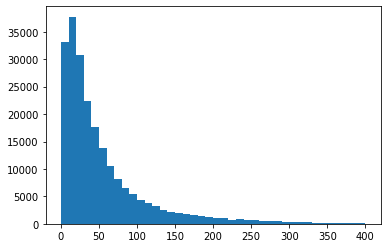

In [15]:
totalNumWords = [len(one_comment) for one_comment in tokenized_train_sen]
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

In [21]:
#GLOVE EMBEDDING

from numpy import array
from numpy import asarray
from numpy import zeros

        
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /kaggle/working/glove.6B.100d.txt
    
embeddings_index = {};


with open('/kaggle/working/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, 100)); #100 embedding dim
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-05-07 17:29:24--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/kaggle/working/glove.6B.100d.txt’

/kaggle/working/glo 100%[===================>] 331.04M   148MB/s    in 2.2s    

2020-05-07 17:29:26 (148 MB/s) - ‘/kaggle/working/glove.6B.100d.txt’ saved [347116733/347116733]



In [36]:
embed_size = 128

def jigsaw_model():
    inp = Input(shape = (max_len, ))    

    x = Embedding(vocab_size, 100, weights=[embeddings_matrix], trainable=False)(inp)
    
    x = Bidirectional(LSTM(60, return_sequences = True))(x)
    x = Dropout(0.2)(x)
    
    x = Bidirectional(LSTM(60, return_sequences = True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.2)(x)
    
    x = Dense(50, activation = 'relu')(x)
    x = Dropout(0.1)(x)
    
    x = Dense(1, activation = 'sigmoid')(x)
    
    model = Model(inputs = inp, outputs = x)
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model
    

In [37]:
#model = create_model(data.max_seq_len, bert_ckpt_file)
model = jigsaw_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 200, 100)          30025900  
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 120)          77280     
_________________________________________________________________
dropout (Dropout)            (None, 200, 120)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 120)          86880     
_________________________________________________________________
global_max_pooling1d (Global (None, 120)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0     

In [38]:
batch_size = 32*8 # for 8 TPU Cores
epochs = 2
history = model.fit(X_t, y, batch_size = batch_size, epochs = epochs, validation_split = 0.1)

#can't validate on the the test set yet as it is multilingual, Will use BERT in another notebook 

Train on 201194 samples, validate on 22355 samples
Epoch 1/2
201194/201194 [==============================] - 413s 2ms/sample - loss: 0.1536 - accuracy: 0.9424 - val_loss: 0.1431 - val_accuracy: 0.9403
Epoch 2/2
201194/201194 [==============================] - 406s 2ms/sample - loss: 0.1194 - accuracy: 0.9538 - val_loss: 0.1687 - val_accuracy: 0.9254


In [39]:
#model.save('/kaggle/working/model.h5')
model.save('/kaggle/working/binary-model.h5')

In [53]:
sentences = 'I will f**k your family up' #only for testing purposes
word_index = tokenizer.word_index

x_test = [[word_index[w] for w in sentences if w in word_index]]

x_test = pad_sequences(x_test, maxlen=max_len) # Should be same which you used for training data

vector = np.array([x_test.flatten()])

preds = model.predict(vector) 

print(preds[0])
if preds[0] >0.5:
    print('toxic')
else:
    print('not toxic')

[0.7115599]
toxic
